***Qual a quantidade de ônibus que tem sua chegada/partida em estações de metrô?***

In [2]:
import requests
import json
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import Comment
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pylab as plt
import folium
import numpy as np
%matplotlib inline

class Busao:
    
    def __init__(self):
        self.url_base = 'http://api.olhovivo.sptrans.com.br/v2.1/'
        self.session = requests.Session()
        self.session = self.get_session('d0c65185a69fdc0d95300821e3aa14b879d324c54784902c147c77e6b8e54e1d')
        self.line_subway = ['blue','beige','lightgray','red','green','pink']
        self.df_bus = pd.DataFrame()
    
    def get_session(self, token):
        '''Autenticar o token do usuário
        '''
        url = self.url_base + 'Login/Autenticar?token=' + token       
        data = self.session.post(url)
        return self.session
    
    def get_subway(self, line):
        '''Consultar todas as linhas de metrô pela cor, através do parâmetro passado
        '''
        line = line.upper()
        url = 'http://www.metro.sp.gov.br/sua-viagem/linha-1-azul/estacao-jabaquara.aspx'
        css = ''
        dict_sub = {'BLUE':'linha-1-azul','GREEN':'linha-2-verde', 'RED':'linha-3-vermelha', 'LIGHTGRAY': 'linha-15-prata', 'BEIGE':'linha-4-amarela',  'PINK': 'linha-5-lilas'}

        page_blue = requests.get(url).content
        soup = BeautifulSoup(page_blue,'lxml')

        if line not in ('BEIGE','PINK'):        
            table_subway = soup.find_all(class_=dict_sub[line])[0].find_all('a')
        else:
            lst_comment = [item for item in soup.findAll(text=lambda text:isinstance(text, Comment)) if item.find(dict_sub[line]) >= 0]
            if len(lst_comment) > 0:
                lst = [comments for comments in soup.findAll(text=lambda text:isinstance(text, Comment)) if comments.find(dict_sub[line]) >= 0]
                table_subway = BeautifulSoup(lst[0],'lxml').find_all(class_=dict_sub[line])[0].find_all('a')            

        lst_subway =[]    
        for item in table_subway:
            lst_subway.append('METRÔ ' + item.text.upper())
            if item.text.upper().find('VILA') >= 0:
                lst_subway.append('METRÔ VL.' + item.text.upper().replace('VILA',''))

        if line == 'GREEN':
            lst_subway.append('TERM. SACOMÃ')
            lst_subway.append('METRÔ - TRIANON - MASP')
        elif line == 'BEIGE':
            lst_subway.append('TERM. PINHEIROS') #linha amarela
        elif line == 'PINK':
            lst_subway.append('METRÔ STA. CRUZ')
            lst_subway.append('METRÔ VL. DAS BELEZAS')
        elif line == 'BLUE':
            lst_subway.append('METRÔ PÇA. DA ÁRVORE')
            lst_subway.append('METRÔ JD. SÃO PAULO')
        elif line == 'RED':
            lst_subway.append('METRÔ GUILHERMINA/ESPERANÇA')
            lst_subway.append('METRÔ STA. CECÍLIA')
        elif line =='SILVER':
            lst_subway.append('TERM. VILA PRUDENTE')
            lst_subway.append('TERM. VL. PRUDENTE')

        return lst_subway
    
    def get_bus(self, bus):
        '''Consultar os ônibus pelo nome do terminal primário/secundário
        '''
        url = self.url_base + 'Linha/Buscar?termosBusca=%s' % bus
        response = self.session.get(url,timeout=20)
        return json_normalize(json.loads(response.text))
    
    def get_line_line(self, color):
        '''Consultar pela cor da linha do metrô do parâmetro passado, todos as ônibus         '''
        df = pd.concat([self.get_line(item, color) for item in self.get_subway(color)], sort=False)
        return df
    
    def get_line(self, subway, color):
        '''Consultar pelo nome do metrô
        '''
        flat = self.get_bus(subway)
        if not flat.empty:
            flat['qty'] = 1
            flat['subway'] = subway
            flat['color'] = color
            flat = flat[(subway == flat['tp']) | (subway == flat['ts'])]
        return flat
    
    def get_lat_long(self, line, color):
        '''Consultar posição atual de uma linha de ônibus 
        '''
        url = self.url_base + 'Previsao/Linha?codigoLinha=%s' % line
        response = self.session.get(url,timeout=20)    
        stopped = json_normalize(json.loads(response.text))['ps'][0]        
        df_line = json_normalize(stopped)
        df_line['line'] = line
        df_line['color'] = color
        return df_line
    
    def get_graphic_line(self, col_color, col_qty, label):
        '''Visualizar gráfico por quantidade e cor da linha do metrô
        '''
        plt.figure(figsize=(8,8))
        plt.xticks(rotation='vertical')
        plt.ylabel(label)
        plt.bar(col_color,col_qty , align='center',color=['y','b','g','w','c','r'])
        
    def get_graphic_qty(self, col_subway, col_qty, label):
        '''Visualizar gráfico por quantidade e nome do metrô
        '''
        plt.figure(figsize=(20,5))
        plt.xticks(rotation='vertical')
        plt.ylabel(label)
        plt.bar(col_subway,col_qty , align='center')
        
    def get_localization(self, df_line):
        '''Consultar posição atual de uma lista de linhas de ônibus
        '''
        for index, line in df_line.iterrows():
            lst_line = self.get_lat_long(line['cl'])
            lst_line['color'] = line['color']
            lst = pd.concat(lst_line)
        return lst
    
    def get_all_bus(self):
        '''Consultar e tratar todas as linhas de ônibus por linha de metrô
        '''
        if len(self.df_bus) > 0:
            return
        self.df_bus = pd.concat([self.get_line_line(item) for item in self.line_subway], sort=False)
        self.df_bus['subway'] = self.df_bus['subway'].apply(lambda x: x.replace('TERM.','METRÔ').replace('VL.', 'VILA'))
    
    def get_total_subway(self):
        '''Agrupar todos os ônibus por linha de metrô e visualizar o gráfico de quantidade
        '''        
        self.get_all_bus()
        df_total = self.df_bus.groupby('subway', as_index=False, sort=True)['qty'].count()
        self.get_graphic_qty(df_total.subway, df_total.qty, 'Bus')
    
    def get_total_line(self):
        '''Consultar todos os ônibus de todas as linhas de mêtro e visualizar o gráfico por linha de metrô
        '''
        self.get_all_bus()
        df_by_color = self.df_bus.groupby('color')['qty'].count()
        df_by_color = pd.DataFrame(df_by_color)
        self.get_graphic_line(df_by_color.index, df_by_color.qty, 'BUS')
        
    def get_localization_line(self):
        '''Consultar e agrupar todas as linhas de ônibus de todos os metrôs
        '''
        self.get_all_bus()
        lst_line = pd.concat([self.get_lat_long(line['cl'], line['color']) for index, line in self.df_bus.iterrows()], sort=True)
        return lst_line
    
    def get_map(self):
        lst_line = bus.get_localization_line()
        sp = folium.Map(
            location=[-23.5489, -46.6388],    # Coordenadas retiradas do Google Maps
            zoom_start=11
        )
        for _, item in lst_line.iterrows():
            folium.Marker(
                location=[item['py'],item['px']],
                icon=folium.Icon(color=item['color'])
            ).add_to(sp)
        return sp

In [3]:
bus = Busao()

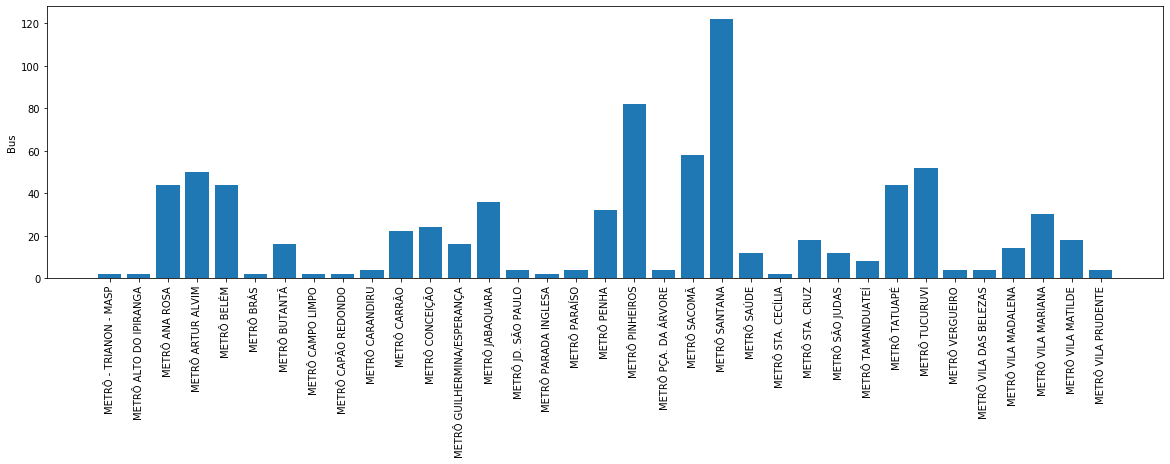

In [4]:
bus.get_total_subway()

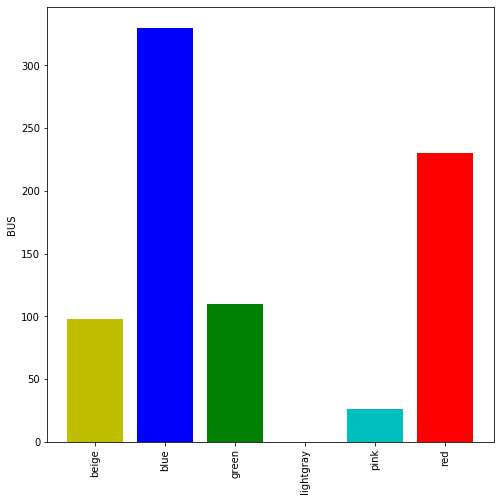

In [5]:
bus.get_total_line()

In [ ]:
bus.get_map()